# 2D MT inversion

We created synthetic data for a simple 2D model in the previous example.  Now let's invert it and test various parameters.

## Learning goals

- Understand the impact of frequencies (start from a couple of frequencies, and more)
- Understand the impact of station spacing
- Understand the impact of `alpha_s`, `alpha_x`, `alpha_y`
- Understand the impact of `p_s`, `p_y`, `p_z`

## Imports

In [1]:
import scipy.sparse as sp
import numpy as np

from scipy.constants import mu_0

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from discretize.tests import check_derivative
import discretize
import discretize.utils as dis_utils
from discretize import TensorMesh

from SimPEG.electromagnetics import natural_source as nsem
from SimPEG.electromagnetics.static import utils as sutils
from SimPEG import (
    maps, utils, optimization, objective_function, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)

from pymatsolver import Pardiso
from scipy.spatial import cKDTree
from scipy.stats import norm

from geoana.em.fdem import skin_depth

import warnings
warnings.filterwarnings("ignore")

## Load Data from MTH5

We created synthetic data and saved it to an MTH5 file now lets retrieve the data.

In [5]:
from pathlib import Path
from mtpy import MTCollection

In [6]:
%%time
with MTCollection() as mc:
    #mc.open_collection(Path('../../../home/005/jp0633/mt_examples/notebooks/simpeg/2d_forward_mth5.h5'))
    mc.open_collection(Path('../../data/transfer_functions/musgraves_tf.h5'))
    mt_data = mc.to_mt_data()
    mt_data.utm_crs = 28353
    profile_mt_data = mt_data.get_profile(129, -27, 134, -27, 8000)

23:11:17T15:31:32 | ERROR | line:230 |mth5.tables.mth5_table | add_row | Data types are not equal. Input dtypes: [('survey', 'S30'), ('station', 'S30'), ('run', 'S20'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('component', 'S20'), ('start', 'S36'), ('end', 'S36'), ('n_samples', '<i4'), ('sample_rate', '<f8'), ('measurement_type', 'S30'), ('azimuth', '<f8'), ('tilt', '<f8'), ('units', 'S60'), ('hdf5_reference', 'O'), ('run_hdf5_reference', 'O'), ('station_hdf5_reference', 'O')] Table dtypes: [('survey', 'S30'), ('station', 'S30'), ('run', 'S20'), ('latitude', '<f8'), ('longitude', '<f8'), ('elevation', '<f8'), ('component', 'S20'), ('start', 'S36'), ('end', 'S36'), ('n_samples', '<i8'), ('sample_rate', '<f8'), ('measurement_type', 'S30'), ('azimuth', '<f8'), ('tilt', '<f8'), ('units', 'S60'), ('hdf5_reference', 'O'), ('run_hdf5_reference', 'O'), ('station_hdf5_reference', 'O')]
23:11:17T15:31:32 | INFO | line:116 |mth5.helpers | close_open_files | ..\..\data\tra

##### Make a Dataframe

In [18]:
profile_mt_data

MTData([('Musgraves_SA.SAA300',
         TF( survey='Musgraves_SA', station='SAA300', latitude=-26.95, longitude=129.93, elevation=563.00 )),
        ('Musgraves_SA.SAA300_pred',
         TF( survey='Musgraves_SA', station='SAA300_pred', latitude=-26.95, longitude=129.93, elevation=0.00 )),
        ('Musgraves_SA.SAA299',
         TF( survey='Musgraves_SA', station='SAA299', latitude=-27.00, longitude=130.43, elevation=512.00 )),
        ('Musgraves_SA.SAA301',
         TF( survey='Musgraves_SA', station='SAA301', latitude=-27.00, longitude=129.50, elevation=517.00 )),
        ('Musgraves_SA.SAA298',
         TF( survey='Musgraves_SA', station='SAA298', latitude=-27.00, longitude=131.01, elevation=527.00 )),
        ('Musgraves_SA.SAA297',
         TF( survey='Musgraves_SA', station='SAA297', latitude=-27.00, longitude=131.50, elevation=554.00 )),
        ('Musgraves_SA.SAA296',
         TF( survey='Musgraves_SA', station='SAA296', latitude=-27.00, longitude=131.97, elevation=499.00 ))

In [24]:
profile_mt_data.remove_station("SAA300_pred", "Musgraves_SA")

In [25]:
mt_df = profile_mt_data.to_dataframe()
mt_df = mt_df.sort_values(["profile_offset", "period"])

In [26]:
mt_df[["survey", "station", "profile_offset", "period"]]

,survey,station,profile_offset,period
0,Musgraves_SA,SAA300,0.00000,8.000000
1,Musgraves_SA,SAA300,0.00000,10.666667
2,Musgraves_SA,SAA300,0.00000,16.000000
3,Musgraves_SA,SAA300,0.00000,21.333333
4,Musgraves_SA,SAA300,0.00000,32.000000
...,...,...,...,...
202,Musgraves_SA,SAA293-2,344424.85505,4096.010486
203,Musgraves_SA,SAA293-2,344424.85505,5461.198187
204,Musgraves_SA,SAA293-2,344424.85505,8192.020972
205,Musgraves_SA,SAA293-2,344424.85505,10922.634976


##### Put data into format wanted by SimPEG

In [28]:
n_stations = mt_df.station.unique().size

# make a station array (x, z)
rx_locs = np.c_[mt_df.profile_offset.unique(), np.zeros(n_stations)]

frequencies = 1./mt_df.period.unique()

app_rho_te = np.zeros((frequencies.size, rx_locs.shape[0]))
app_rho_tm = np.zeros((frequencies.size, rx_locs.shape[0]))
phase_te = np.zeros((frequencies.size, rx_locs.shape[0]))
phase_tm = np.zeros((frequencies.size, rx_locs.shape[0]))
for index, station in enumerate(mt_df.station.unique()):
    sdf = mt_df[mt_df.station == station]
    sdf.sort_values("period")
    app_rho_te[:, index] = sdf.res_xy
    app_rho_tm[:, index] = sdf.res_yx
    phase_te[:, index] = sdf.phase_xy
    phase_tm[:, index] = sdf.phase_yx
    

## Model Errors

Here we can set the data errors telling the inversion code how well to fit each point.  

 - **Apparent resistivity** is often a percentage.
 - **Phase** is usually a set value in degrees.

In [29]:
relative_error =  0.05
floor_error = 2

app_rho_err_tm = abs(app_rho_tm) * relative_error
app_rho_err_te = abs (app_rho_te) * relative_error
phase_err_tm = np.ones_like(phase_tm) * floor_error
phase_err_te = np.ones_like(phase_te) * floor_error

## Inversion parameters

In [30]:
alpha_s = 1e-5     # set how threshold to change model
alpha_y = 1/5.     # 
alpha_z = 1.       # 
rho_0 = 500.       # starting resistivity
maxIter = 30       # maximum number of iterations
use_irls = False   # use iterative least-squares
p_s=2              # smoothing (norm)
p_y=0              # smoothing (norm)
p_z=0              # smoothing (norm)

## Create Model Mesh

In [31]:
def generate_2d_mesh_for_mt(
    rx_locs,            # station locations
    frequencies,        # frequencies to invert 
    sigma_background,   # background conductivity
    z_factor_max=5,     # maximum factor in vertical direction (factor of skin depth)  
    z_factor_min=5,     # minimum factor in vertical direction (factor of skin depth)
    pfz_down = 1.2,     # geometric factor for increasing cell size in subsurface
    pfz_up = 1.5,       # geometric factor for increasing cell size in air
    npadz_up = 5,       # number of air cells
    x_factor_max = 2,   # maximum factor in horizontal direction
    spacing_factor = 4, # number of cells between stations
    pfx = 1.5,          # geometric factor for increasing cell size in horizontal direction
    n_max=1000          # maximum number of vertical cells
):
    # get minimum cell size (first layer thickness)
    dz_min = np.round(skin_depth(frequencies.max(), sigma_background) / z_factor_max) 
    lz = skin_depth(sigma_background, frequencies.min()) * z_factor_max
    
    # Setting the domain length in subsurface
    for nz_down in range(n_max):
        hz_down = dz_min*pfz_down**np.arange(nz_down)[::-1]
        if hz_down.sum() > lz:
            break
    # create air layers
    hz_up = [(dz_min, npadz_up, pfz_up)]
    hz_up = dis_utils.unpack_widths(hz_up)
    
    # combine air and subsurface
    hz = np.r_[hz_down, hz_up]
    
    # Setting the cells in lateral dimension
    # station spacing
    d_station = np.diff(rx_locs[:,0]).min()
    # minimum cell width
    dx_min = np.round(d_station/spacing_factor)
    # survey span
    lx = rx_locs[:,0].max() - rx_locs[:,0].min()
    ncx = int(lx / dx_min)
    
    # make padding cells
    lx_pad = skin_depth(sigma_background, frequencies.min()) * x_factor_max
    for npadx in range(n_max):
        hx_pad = dis_utils.unpack_widths([(dx_min, npadx, -pfx)])
        if hx_pad.sum()>lx_pad:
            break
    # combine paddin cells with station area cells
    hx = [(dx_min, npadx, -pfx), (dx_min, ncx), (dx_min, npadx, pfx)]  
    
    # make a discretize.TensorMesh object
    mesh = discretize.TensorMesh([hx, hz])
    
    # get the lower left corner of the mesh, the origin
    mesh.origin = np.r_[-mesh.h[0][:npadx].sum()+rx_locs[:,0].min(), -hz_down.sum()]   
    
    print (mesh)
    return mesh

In [32]:
mesh = generate_2d_mesh_for_mt(rx_locs, frequencies, 1e-2)
ind_active = mesh.cell_centers[:,1]<0.


  TensorMesh: 87,500 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x   2500 -1,396,187.83  1,740,587.83    140.00 465,535.94    1.50
   y     35 -3,364,816.83     56,317.22  2,847.00 563,175.30    1.50




<Axes: xlabel='x1', ylabel='x2'>

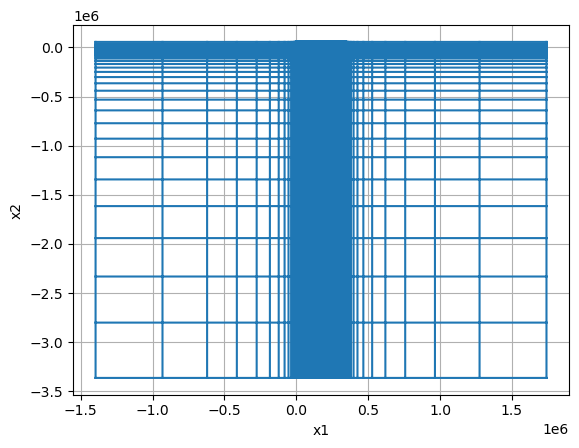

In [34]:
mesh.plot_grid()

## Create Sources and Receivers

In [35]:
# simulation class for TM mode
rx_list_tm = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="xy", component="phase"
    ),
]
src_list_tm = [nsem.sources.Planewave(rx_list_tm, frequency=f) for f in frequencies]
survey_tm = nsem.Survey(src_list_tm)

act_map = maps.InjectActiveCells(mesh, ind_active, np.log(1e-8))
exp_map = maps.ExpMap(mesh=mesh)
sigma_map = exp_map * act_map

sim_tm= nsem.simulation.Simulation2DElectricField(
    mesh,
    survey=survey_tm,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

# simulation class for TE mode
rx_list_te = [
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]
src_list_te = [nsem.sources.Planewave(rx_list_te, frequency=f) for f in frequencies]
survey_te = nsem.Survey(src_list_te)

sim_te = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey_te,
    sigmaMap=sigma_map,
    solver=Pardiso,
)

In [36]:
dobs_te = np.hstack((app_rho_te, phase_te)).flatten()
dobs_tm = np.hstack((app_rho_tm, phase_tm)).flatten()

std_te = np.hstack((app_rho_err_te, phase_err_te)).flatten()
std_tm = np.hstack((app_rho_err_tm, phase_err_tm)).flatten()

In [37]:
m0 = np.ones(ind_active.sum()) * np.log(1./rho_0)

## Setup Inversion

In [38]:
te_data_object = data.Data(survey_te, dobs=dobs_te, standard_deviation=std_te) 
tm_data_object = data.Data(survey_tm, dobs=dobs_tm, standard_deviation=std_tm) 
dmis_te = data_misfit.L2DataMisfit(data=te_data_object, simulation=sim_te)
dmis_tm = data_misfit.L2DataMisfit(data=tm_data_object, simulation=sim_tm)
dmis = dmis_te + dmis_tm

# Define the regularization (model objective function)
reg = regularization.Sparse(
    mesh,
    indActive=ind_active,
    reference_model=m0,
    alpha_s=alpha_s,
    alpha_x=alpha_y,
    alpha_y=alpha_z,
    mapping=maps.IdentityMap(nP=int(ind_active.sum()))
)

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=maxIter, maxIterCG=30)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define MT Inversion Directives
# ------------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1e0)

if use_irls:
    reg.norms = [p_s, p_y, p_z]
    # Reach target misfit for L2 solution, then use IRLS until model stops changing.
    IRLS = directives.Update_IRLS(max_irls_iterations=40, minGNiter=1, f_min_change=1e-5)

    # The directives are defined as a list.
    directives_list = [
        IRLS,
        starting_beta,
        save_dictionary,
    ]
else:
    directives_list = [
        starting_beta,
        beta_schedule,
        save_dictionary,
        target_misfit,
    ]

    
#####################################################################
# Running the MT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
mt_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion

In [ ]:
%%time

recovered_conductivity_model = mt_inversion.run(m0)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DMagneticField problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.01e+01  8.65e+08  0.00e+00  8.65e+08    7.07e+07      0              


In [ ]:
output_dict = save_dictionary.outDict
target_misfit = (dobs_te.size+dobs_tm.size) / 2.
iterations = list(output_dict.keys())
n_iteration = len(iterations)
phi_ds = np.zeros(n_iteration)
phi_ms = np.zeros(n_iteration)
betas = np.zeros(n_iteration)
for ii, iteration in enumerate(iterations):
    phi_ds[ii] = output_dict[iteration]['phi_d']
    phi_ms[ii] = output_dict[iteration]['phi_m']
    betas[ii] = output_dict[iteration]['beta']

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
def tikhonov_curve(iteration, scale='log'):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.plot(phi_ms, phi_ds)
    ax.plot(phi_ms[iteration-1], phi_ds[iteration-1], 'ro')
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    xlim = ax.get_xlim()
    ax.plot(xlim, np.ones(2) * target_misfit, '--')
    ax.set_title("Iteration={:d}, Beta = {:.1e}".format(iteration, betas[iteration-1]))
    ax.set_xlim(xlim)
    plt.show()

In [ ]:
from ipywidgets import interact, widgets
Q_iter = interact(
    tikhonov_curve, 
    iteration=widgets.IntSlider(min=1, max=int(n_iteration), value=n_iteration),
    scale=widgets.RadioButtons(options=['linear', 'log'])
)

In [ ]:
from matplotlib.colors import LogNorm
iteration = Q_iter.widget.kwargs['iteration']
m = output_dict[iteration]['m']

In [ ]:
def foo_model(iteration):
    fig, ax = plt.subplots(1,1, figsize=(10, 6))
    m = output_dict[iteration]['m']
    sigma = np.ones(mesh.nC) * 1e-8
    sigma[ind_active] = np.exp(m)
    sigma_min = 1e-3
    sigma_max = 10
    grid= False
    out = mesh.plot_image(
        sigma, grid=grid, ax=ax, pcolor_opts={'norm':LogNorm(vmin=sigma_min, vmax=sigma_max), 'cmap':'turbo'},
        range_x=(-60000, 60000), range_y=(-30000, 0)
    )
    cb = plt.colorbar(out[0], fraction=0.01, ax=ax)
    cb.set_label("Conductivity (S/m)")
    ax.set_aspect(1)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Elevation (m)")
    ax.plot(rx_locs[:,0], rx_locs[:,1], 'ro')
    #out = mesh_true.plot_image(
    #    sigma_true, grid=grid, ax=ax1, pcolor_opts={'norm':LogNorm(vmin=sigma_min, vmax=sigma_max), 'cmap':'turbo'},
    #    range_x=(-60000, 60000), range_y=(-30000, 0)
    #)
    #cb = plt.colorbar(out[0], fraction=0.01, ax=ax1)
    #cb.set_label("Conductivity (S/m)")
    #ax1.set_aspect(1)
    #ax1.set_xlabel("Easting (m)")
    #ax1.set_ylabel("Elevation (m)")

In [ ]:
Q_misfit = interact(
    foo_model, 
    iteration=widgets.IntSlider(min=1, max=n_iteration, value=iteration),
)    

In [ ]:
pred_te = sim_te.dpred(m)
pred_tm = sim_tm.dpred(m)

In [ ]:
n_freq = len(frequencies)
n_rx = rx_locs.shape[0]

In [ ]:
PRED_te = pred_te.reshape((n_freq, 2, n_rx))
PRED_tm = pred_tm.reshape((n_freq, 2, n_rx))

rho_app_te_pred = PRED_te[:,0,:]
rho_app_tm_pred = PRED_tm[:,0,:]

phase_te_pred = PRED_te[:,1,:]
phase_tm_pred = PRED_tm[:,1,:]

DOBS_te = dobs_te.reshape((n_freq, 2, n_rx))
DOBS_tm = dobs_tm.reshape((n_freq, 2, n_rx))

rho_app_te_dobs = DOBS_te[:,0,:]
rho_app_tm_dobs = DOBS_tm[:,0,:]

phase_te_dobs = DOBS_te[:,1,:]
phase_tm_dobs = DOBS_tm[:,1,:]

In [ ]:
def foo_pred(irx):
    import matplotlib
    matplotlib.rcParams['font.size'] = 10

    fig, axs = plt.subplots(4,1, figsize=(8, 10))
    ax1, ax2, ax3, ax4 = axs
    ax1.loglog(1./frequencies, rho_app_te_pred[:, irx], color='C0')
    ax1.loglog(1./frequencies, rho_app_te_dobs[:, irx], 'x', color='C0')
    ax2.loglog(1./frequencies, rho_app_tm_pred[:, irx], color='C1')
    ax2.loglog(1./frequencies, rho_app_tm_dobs[:, irx], 'x', color='C1')
    for ax in axs[:2]:
        ax.set_ylim(1, 1000)
        ax.set_ylabel("App. Res. (Ohm-m)")
        ax.grid(which='both', alpha=0.3)
    ax3.semilogx(1./frequencies, phase_te_pred[:, irx], color='C0')
    ax3.semilogx(1./frequencies, phase_te_dobs[:, irx], 'x', color='C0')
    ax4.semilogx(1./frequencies, phase_tm_pred[:, irx]+180, color='C1')
    ax4.semilogx(1./frequencies, phase_tm_dobs[:, irx]+180, 'x', color='C1')
    for ax in axs[2:]:
        ax.set_ylim(0, 90)
        ax.set_ylabel("Phase (degree)")
        ax.grid(which='both', alpha=0.3)
    ax4.set_xlabel("Period (s)")

In [ ]:
Q_misfit = interact(
    foo_pred, 
    irx=widgets.IntSlider(min=0, max=int(n_rx)-1, value=0),
)